# Prophet Forecasting

**Notebook Contents:**

* [Data Preprocessing](#scrollTo=CvyZESCEoryn&line=1&uniqifier=1)
* [Exploratory Data Analysis (EDA)](#scrollTo=JKWng1hbAa05)
* [Holiday Treatment](#scrollTo=2wbCCxcfQu__&line=1&uniqifier=1)
* [Feature Engineering](#scrollTo=3BhzLNvkH8gL)
* [Prophet Model Overview](#scrollTo=wufS-VgILorv&line=1&uniqifier=1)
* [Regression Coefficients](#scrollTo=HB05YGGWRbNM&line=1&uniqifier=1)
* [Cross Validation](#scrollTo=KCvsGZqn52fi&line=1&uniqifier=1)
* [Hyperparameter Tuning](#scrollTo=XPqy2UedMe2k&line=1&uniqifier=1)
* [Model Prediction](#scrollTo=6KVGP_cCU1lf&line=1&uniqifier=1)
* [Prediction Diagnostics](#scrollTo=JQL8zI31lI-A&line=1&uniqifier=1)

In [ ]:
# !pip freeze

In [ ]:
# Mount Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Change directory to the desired folder in Google Drive
# %cd /content/drive/MyDrive/Colab/Machine Learning/Forecasting/Forecasting with Prophet/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques/Prophet

/content/drive/MyDrive/Colab/Machine Learning/Forecasting/Forecasting with Prophet/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques/Prophet


In [ ]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import ParameterGrid
import math
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import plotly.graph_objects as go

In [ ]:
# Load the daily bike sharing train data
df = pd.read_csv("data/Daily Bike Sharing training.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
# Display information about the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     701 non-null    int64  
 1   dteday      701 non-null    object 
 2   season      701 non-null    int64  
 3   yr          701 non-null    int64  
 4   mnth        701 non-null    int64  
 5   holiday     701 non-null    int64  
 6   weekday     701 non-null    int64  
 7   workingday  701 non-null    int64  
 8   weathersit  701 non-null    int64  
 9   temp        701 non-null    float64
 10  atemp       701 non-null    float64
 11  hum         701 non-null    float64
 12  windspeed   701 non-null    float64
 13  casual      701 non-null    int64  
 14  registered  701 non-null    int64  
 15  cnt         701 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 87.8+ KB


# Data Preprocessing

In [ ]:
# Change the time Series variable name
# target variable as 'y'
# date as 'ds'
df = df.rename(columns = {'cnt': 'y',
                          'dteday': 'ds'})

df['ds'] = pd.to_datetime(df['ds'], format = "%m/%d/%Y")

# Create dummy variables for the categorical column 'weathersit' in DataFrame 'df'
weather_sit = pd.get_dummies(df['weathersit'], drop_first = True)
# Concatenate the original DataFrame 'df' with the dummy variables 'weather_sit'
df = pd.concat([df, weather_sit], axis = 1)

df = df.rename(columns = {2: 'weathersit_2',
                          3: 'weathersit_3'})

# Drop Variables That Are Not Needed
df.drop(columns = ['instant', 'season', 'yr', 'mnth', 'weekday',
                   'casual', 'registered'], inplace = True)

# Replace 29/30 of October 2012 with the values of 28th
# 28th because in EDA weekly seasonality is not obvious
to_replace = df.loc[df.ds == '2012-10-28'].y.values[0]
df.loc[df.ds == '2012-10-29', 'y'] = to_replace
df.loc[df.ds == '2012-10-30', 'y'] = to_replace

df.head()

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False


# Exploratory Data Analysis

In [ ]:
# Create a copy of the df with index
df_temp = df.copy()
df_temp.set_index('ds', inplace = True)

In [ ]:
# Set the frequency of the DataFrame index to daily ("D")
df_temp.index.freq = "D"
df_temp.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25',
               '2012-11-26', '2012-11-27', '2012-11-28', '2012-11-29',
               '2012-11-30', '2012-12-01'],
              dtype='datetime64[ns]', name='ds', length=701, freq='D')

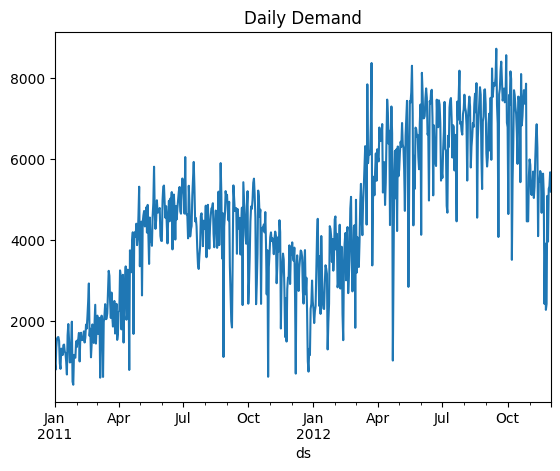

In [ ]:
# Daily demand line plot
df_temp['y'].plot(title = 'Daily Demand')
plt.show()

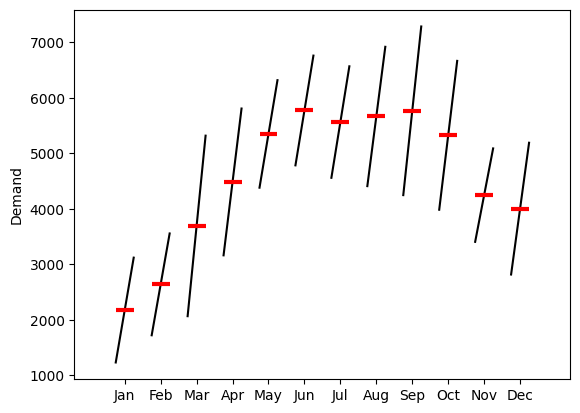

In [ ]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of bike sharing demand
month_plot(df_temp['y'].resample('ME').mean(),
           ylabel = 'Demand')
plt.show()

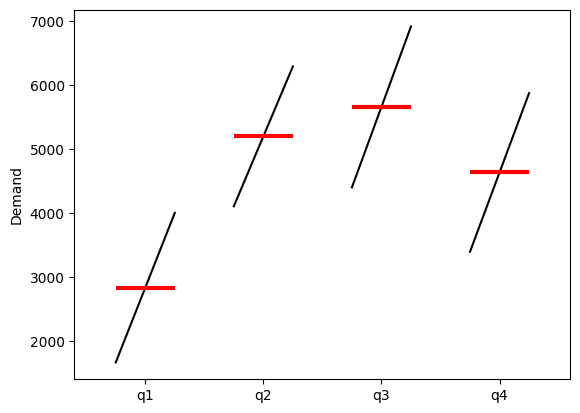

In [ ]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of bike sharing demand
quarter_plot(df_temp['y'].resample('QE').mean(),
           ylabel = 'Demand')
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.

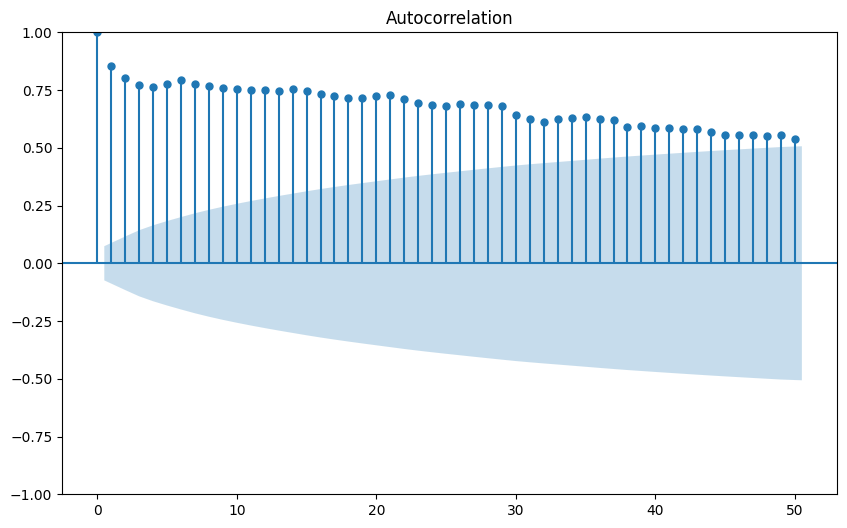

In [ ]:
# Plot the autocorrelation (ACF) of bike sharing demand
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df_temp['y'], lags = 50, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

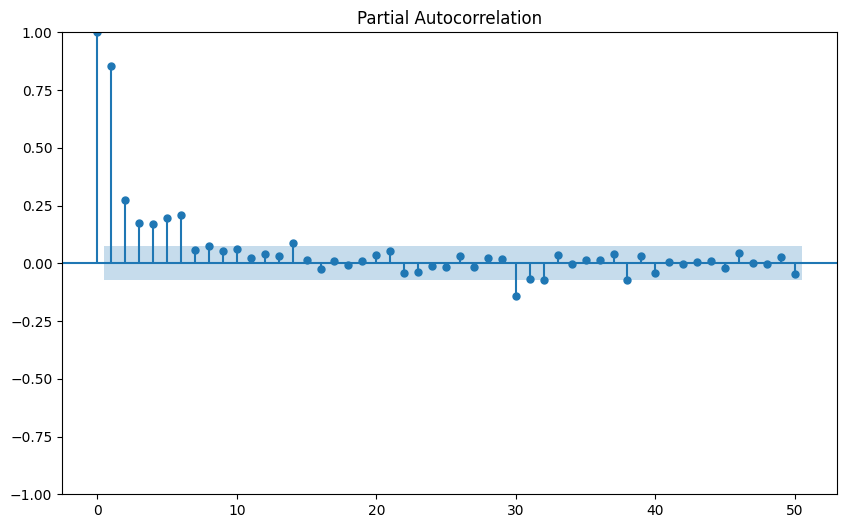

In [ ]:
# Plot the partial autocorrelation (PACF) of bike sharing demand
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df_temp['y'], lags = 50, ax = ax)
plt.show()

# Data Visualization

In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2011-01-01 to 2012-12-01
Freq: D
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   holiday       701 non-null    int64  
 1   workingday    701 non-null    int64  
 2   weathersit    701 non-null    int64  
 3   temp          701 non-null    float64
 4   atemp         701 non-null    float64
 5   hum           701 non-null    float64
 6   windspeed     701 non-null    float64
 7   y             701 non-null    int64  
 8   weathersit_2  701 non-null    bool   
 9   weathersit_3  701 non-null    bool   
dtypes: bool(2), float64(4), int64(4)
memory usage: 50.7 KB


In [ ]:
df_temp.describe()

,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,0.028531,0.684736,1.385164,0.502732,0.480847,0.625717,0.190534,4539.168331
std,0.166602,0.464953,0.542489,0.182781,0.162584,0.141988,0.076740,1927.887940
min,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,431.000000
25%,0.000000,0.000000,1.000000,0.343478,0.348470,0.519167,0.134958,3214.000000
50%,0.000000,1.000000,1.000000,0.514167,0.503146,0.623750,0.182221,4541.000000
75%,0.000000,1.000000,2.000000,0.660000,0.613025,0.728750,0.233221,6041.000000
max,1.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,8714.000000


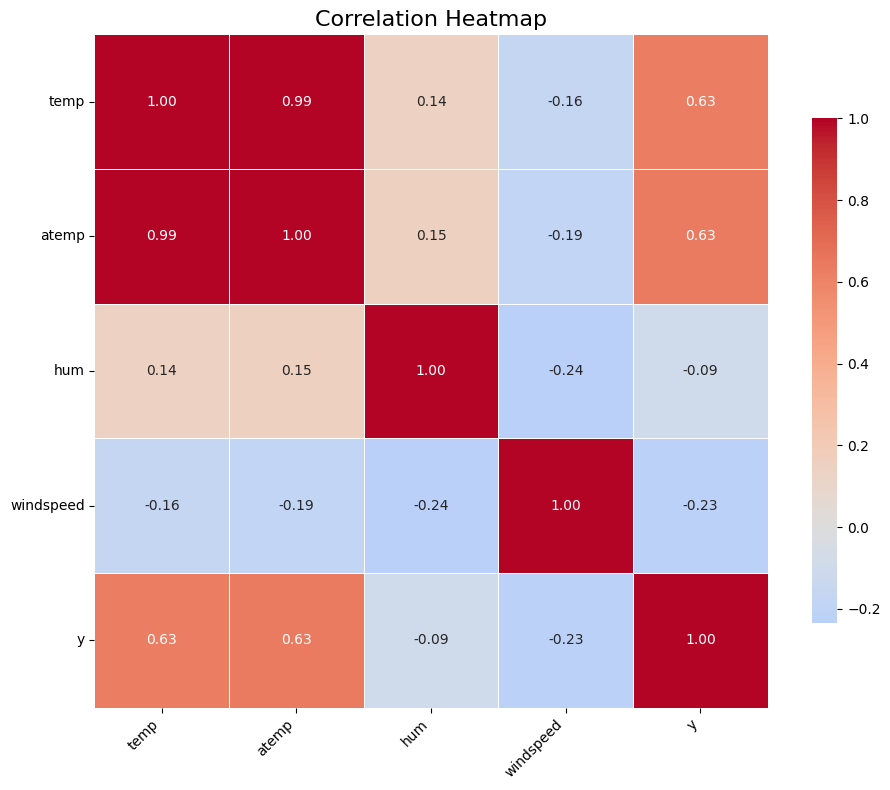

In [ ]:
cols = ['temp', 'atemp', 'hum', 'windspeed', 'y']

# 1. Compute correlation matrix
corr_matrix = df_temp[cols].corr(numeric_only=True)  # Use numeric_only=True for pandas >=1.5

# 2. Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       # Show correlation coefficients
    cmap='coolwarm',  # Color map
    center=0,         # Center the colormap at zero
    fmt=".2f",        # Format the numbers to 2 decimal places
    square=True,      # Make cells square
    linewidths=0.5,   # Cell border lines
    cbar_kws={"shrink": 0.75}  # Shrink color bar
)
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

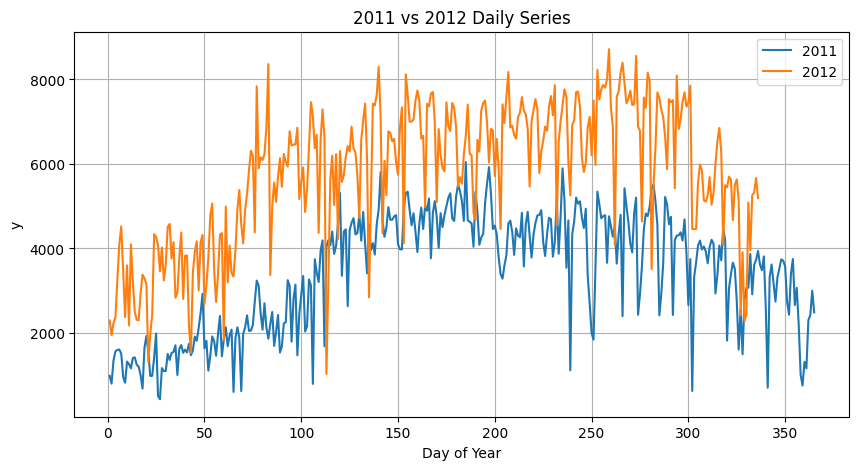

In [ ]:
#YOY comparison
# Copy and prepare data
df_temp_plot = df_temp.copy()
df_temp_plot['year'] = df_temp_plot.index.year
df_temp_plot['day_of_year'] = df_temp_plot.index.dayofyear

# Pivot so each year becomes its own column
df_pivot = df_temp_plot.pivot(index='day_of_year', columns='year', values='y')

# Plot
plt.figure(figsize=(10, 5))
for year in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[year], label=str(year))

plt.xlabel('Day of Year')
plt.ylabel('y')
plt.title('2011 vs 2012 Daily Series')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-244442626.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_temp.resample('M').mean()['y'].plot(title = 'Mean Monthly Demand')


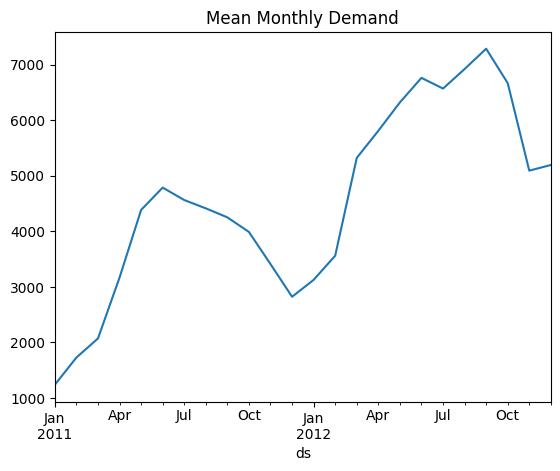

In [ ]:
df_temp.resample('M').mean()['y'].plot(title = 'Mean Monthly Demand')
plt.show()

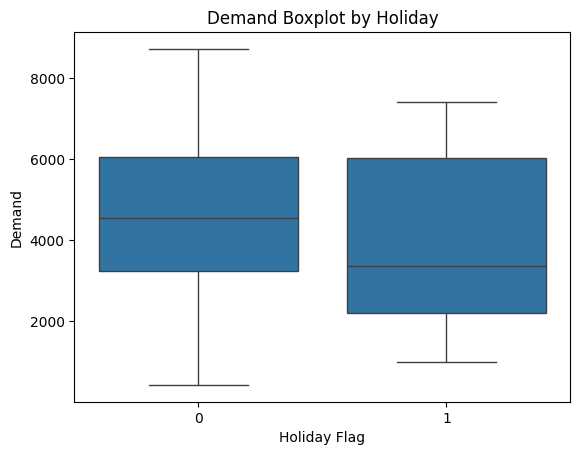

In [ ]:
sns.boxplot(data=df_temp, x="holiday", y="y")
# sns.catplot(data=tips, x="day", y="total_bill", kind="box")
plt.title('Demand Boxplot by Holiday')
plt.xlabel('Holiday Flag')
plt.ylabel('Demand')
plt.show()

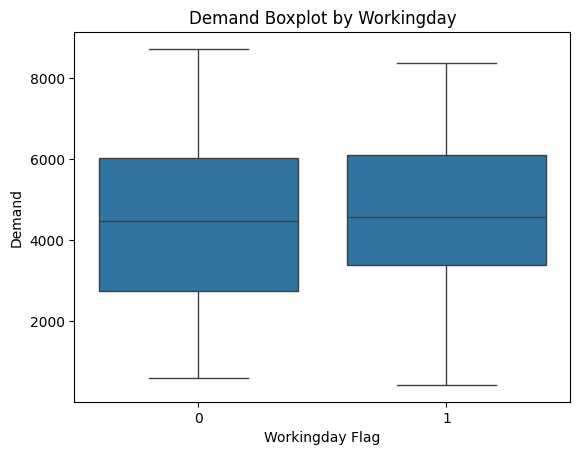

In [ ]:
sns.boxplot(data=df_temp, x="workingday", y="y")
# sns.catplot(data=tips, x="day", y="total_bill", kind="box")
plt.title('Demand Boxplot by Workingday')
plt.xlabel('Workingday Flag')
plt.ylabel('Demand')
plt.show()

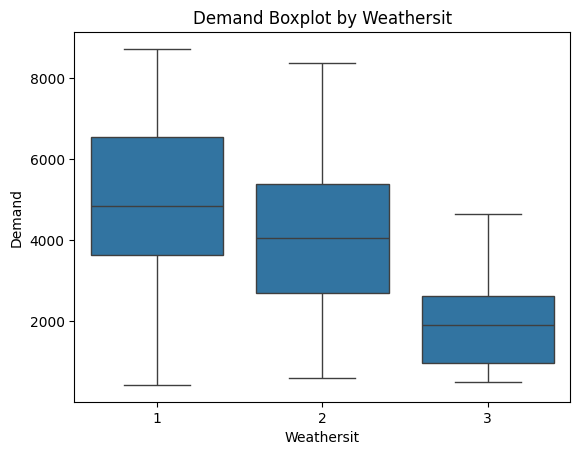

In [ ]:
sns.boxplot(data=df_temp, x="weathersit", y="y")
# sns.catplot(data=tips, x="day", y="total_bill", kind="box")
plt.title('Demand Boxplot by Weathersit')
plt.xlabel('Weathersit')
plt.ylabel('Demand')
plt.show()

### Proportion of rides by dayofweek

In [ ]:
df_temp['dayofweek'] = df_temp.index.dayofweek
df_temp['month'] = df_temp.index.month

In [ ]:
df_temp.groupby('dayofweek').agg(
     sum_rides=('y', 'sum'),
    #  avg_rides=('y', 'mean'),
     ) /df_temp['y'].sum()

,sum_rides
dayofweek,
0,0.138375
1,0.142615
2,0.143400
3,0.147157
4,0.147850
5,0.145850
6,0.134754


In [ ]:
df_month_trend = df_temp.groupby('month').agg(
     sum_rides=('y', 'sum'),
    #  avg_rides=('y', 'mean'),
     ) /df_temp['y'].sum()

df_month_trend

,sum_rides
month,
1,0.042406
2,0.047566
3,0.071943
4,0.084569
5,0.104240
6,0.108846
7,0.108407
8,0.110370
9,0.108735


Text(0, 0.5, 'Prop of Rides')

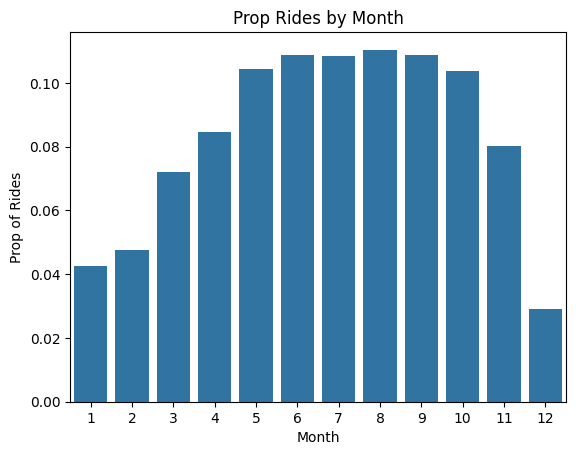

In [ ]:
# sns.barplot() aggregates the numeric variable, uses the mean by default
# also produces bootstrapped confidence intervals
sns.barplot(data=df_month_trend, x=df_month_trend.index, y="sum_rides")
# sns.barplot(data=df, x="Campaign_Type", y="Revenue", estimator="mean", hue="Campaign_Type", kind="bar")
plt.title('Prop Rides by Month')
plt.xlabel('Month')
plt.ylabel('Prop of Rides')

In [ ]:
# pivot table with 1 index and 1 column
df_month_dow = df_temp.pivot_table(index=['month'], columns=['dayofweek'], values=['y'], aggfunc=['sum'])
df_month_dow

sum                                          
               y                                          
dayofweek      0      1      2      3      4      5      6
month                                                     
1          19268  23110  17109  20106  19572  17609  18159
2          20835  22592  25320  23028  23465  18132  17980
3          28365  32166  33030  38170  35332  35449  26408
4          40642  36447  34647  38112  39483  40011  39752
5          40611  50250  46073  53034  46008  47828  47882
6          43826  45447  51309  50596  50547  57094  47523
7          52124  52598  46512  44989  48653  47091  52981
8          49665  53374  60769  54345  53626  41791  37624
9          45097  41476  45346  49370  51723  57543  55436
10         50761  48944  49543  44298  44986  49006  42614
11         37267  36362  37227  35949  40713  34304  33009
12         11841  11029   9407  16249  16345  18230   9413

In [ ]:
# calculate row totals
row_totals = df_month_dow.sum(axis=1)

# calculate perc of sales from pivot table output
df_month_dow_prop = df_month_dow.div(row_totals, axis=0)
df_month_dow_prop

sum                                                    \
                  y                                                     
dayofweek         0         1         2         3         4         5   
month                                                                   
1          0.142797  0.171270  0.126796  0.149007  0.145050  0.130502   
2          0.137659  0.149268  0.167292  0.152149  0.155036  0.119800   
3          0.123908  0.140512  0.144286  0.166739  0.154342  0.154853   
4          0.151033  0.135443  0.128754  0.141631  0.146726  0.148688   
5          0.122438  0.151499  0.138905  0.159892  0.138710  0.144197   
6          0.126540  0.131220  0.148145  0.146087  0.145945  0.164849   
7          0.151107  0.152481  0.134838  0.130423  0.141044  0.136516   
8          0.141418  0.151979  0.173035  0.154744  0.152696  0.118997   
9          0.130342  0.119876  0.131061  0.142692  0.149492  0.166314   
10         0.153750  0.148247  0.150061  0.134175  0.136258  0.148435   
11         0.146242  0.142691  0.146085  0.141070  0.159765  0.134615   
12         0.127991  0.119214  0.101682  0.175638  0.176676  0.197051   

                     
                     
dayofweek         6  
month                
1          0.134578  
2          0.118796  
3          0.115359  
4          0.147725  
5          0.144359  
6          0.137214  
7          0.153591  
8          0.107132  
9          0.160224  
10         0.129074  
11         0.129533  
12         0.101747

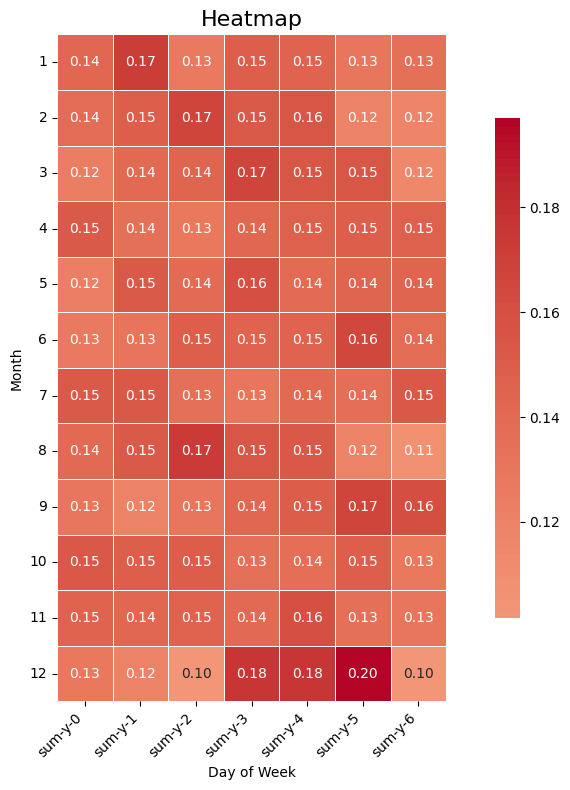

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_month_dow_prop,
    annot=True,       # Show correlation coefficients
    cmap='coolwarm',  # Color map
    center=0,         # Center the colormap at zero
    fmt=".2f",        # Format the numbers to 2 decimal places
    square=True,      # Make cells square
    linewidths=0.5,   # Cell border lines
    cbar_kws={"shrink": 0.75}  # Shrink color bar
)
plt.title("Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Day of Week')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

---

## Holidays Treatment

| **Column**     | **Description**                                                                  | **Required?** | **Example Value(s)**           | **Intuition**                                                                                  |
| -------------- | -------------------------------------------------------------------------------- | ------------- | ------------------------------ | ---------------------------------------------------------------------------------------------- |
| `holiday`      | Name of the holiday (used for labeling and grouping).                            | ✅ Yes         | `"New Year's Day"`, `"Diwali"` | Helps Prophet know which holiday this row refers to (can group multiple dates under one name). |
| `ds`           | Date of the holiday occurrence.                                                  | ✅ Yes         | `"2012-12-25"`                 | The specific date the holiday falls on (can have multiple years).                              |
| `lower_window` | Days *before* `ds` where the holiday effect starts.                              | ❌ Optional    | `-1`, `-7`                     | Useful for holidays with effects that begin before the actual date (e.g., shopping ramp-up).   |
| `upper_window` | Days *after* `ds` where the effect continues.                                    | ❌ Optional    | `1`, `3`                       | Useful when holidays affect days after (e.g., long weekends, post-holiday sales).              |
| `prior_scale`  | Override default regularization for this holiday (how strong its effect can be). | ❌ Optional    | `5.0`, `20.0`                  | Higher value = stronger effect allowed (overrides `holidays_prior_scale` globally).            |

In [ ]:
# Check the holidays in our df
df[df.holiday == 1].ds

,ds
16,2011-01-17
51,2011-02-21
104,2011-04-15
149,2011-05-30
184,2011-07-04
247,2011-09-05
282,2011-10-10
314,2011-11-11
327,2011-11-24
359,2011-12-26


In [ ]:
# Define holiday events
# general holiday
gen_holidays = pd.DataFrame({'holiday': 'gen_holi',
                             'ds': df[df.holiday == 1].ds,
                             'lower_window': -2,
                             'upper_window': 2})
# Christmas
xmas = pd.DataFrame({'holiday': 'christmas',
                     'ds': pd.to_datetime(['2011-12-24', '2012-12-24']),
                             'lower_window': -5,
                             'upper_window': 3})
# New Year's eve
nye = pd.DataFrame({'holiday': 'new_years',
                     'ds': pd.to_datetime(['2011-12-31', '2012-12-31']),
                             'lower_window': -3,
                             'upper_window': 3})
# Easter
easter = pd.DataFrame({'holiday': 'easter',
                     'ds': pd.to_datetime(['2011-04-24', '2012-04-08']),
                     'lower_window': -3,
                             'upper_window': 3})

In [ ]:
# Combine all the holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter])
holidays

,holiday,ds,lower_window,upper_window
16,gen_holi,2011-01-17,-2,2
51,gen_holi,2011-02-21,-2,2
104,gen_holi,2011-04-15,-2,2
149,gen_holi,2011-05-30,-2,2
184,gen_holi,2011-07-04,-2,2
247,gen_holi,2011-09-05,-2,2
282,gen_holi,2011-10-10,-2,2
314,gen_holi,2011-11-11,-2,2
327,gen_holi,2011-11-24,-2,2
359,gen_holi,2011-12-26,-2,2


# Feature Engineering

Purpose of lagged values:
- Time series often have autocorrelation, where past values influence future values. Lagged features allow the model to learn from these historical patterns.
- Lagged values give the model information about recent trends and behaviors.
- Lags at specific intervals (e.g., 7 days, 12 months) can help capture seasonal patterns.
- Many time series are autoregressive, where future values depend on past values. Lagged features directly model this dependency.




In [ ]:
# Series.shift(n) - each value is moved to the n row(s) below its current position

# Create lagged values for the regressors 'temp' and 'atemp' with specified lags
for lag in [1,3,5,7]:
  df[f'temp_lag_{lag}'] = df['temp'].shift(lag)  # Create lagged values for 'temp'
  df[f'atemp_lag_{lag}'] = df['atemp'].shift(lag)  # Create lagged values for 'atemp'

df.head()

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3,temp_lag_1,atemp_lag_1,temp_lag_3,atemp_lag_3,temp_lag_5,atemp_lag_5,temp_lag_7,atemp_lag_7
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False,0.344167,0.363625,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False,0.363478,0.353739,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False,0.196364,0.189405,0.344167,0.363625,NaN,NaN,NaN,NaN
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False,0.200000,0.212122,0.363478,0.353739,NaN,NaN,NaN,NaN


In [ ]:
# Correlation matrix between the lagged values and y
columns = ['y'] + [f'{var}_lag_{lag}' for var in ['temp', 'atemp'] for lag in [1,3,5,7]]
df[columns].corr()

,y,temp_lag_1,temp_lag_3,temp_lag_5,temp_lag_7,atemp_lag_1,atemp_lag_3,atemp_lag_5,atemp_lag_7
y,1.000000,0.590368,0.581922,0.589976,0.595830,0.586681,0.577076,0.587374,0.591886
temp_lag_1,0.590368,1.000000,0.892245,0.861173,0.864545,0.991526,0.882663,0.847990,0.852673
temp_lag_3,0.581922,0.892245,1.000000,0.891829,0.860613,0.877489,0.991519,0.882187,0.847451
temp_lag_5,0.589976,0.861173,0.891829,1.000000,0.891432,0.848465,0.877082,0.991490,0.881814
temp_lag_7,0.595830,0.864545,0.860613,0.891432,1.000000,0.853113,0.847940,0.876584,0.991475
atemp_lag_1,0.586681,0.991526,0.877489,0.848465,0.853113,1.000000,0.869430,0.836607,0.842372
atemp_lag_3,0.577076,0.882663,0.991519,0.877082,0.847940,0.869430,1.000000,0.868989,0.836076
atemp_lag_5,0.587374,0.847990,0.882187,0.991490,0.876584,0.836607,0.868989,1.000000,0.868539
atemp_lag_7,0.591886,0.852673,0.847451,0.881814,0.991475,0.842372,0.836076,0.868539,1.000000


# Prophet Model

In [ ]:
# Kick out all lagged variables but the temp_lag1
df = df.iloc[:,:-7]
df.head()

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3,temp_lag_1
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False,NaN
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False,0.344167
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False,0.363478
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False,0.196364
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False,0.200000


In [ ]:
# Remove any NAs
df = df.dropna()

In [ ]:
from prophet import Prophet

# Prophet Model Overview

| **Parameter**              | **Description**                                                             | **Possible Values / Default**                              | **Intuition**                                                               |
| -------------------------- | --------------------------------------------------------------------------- | ---------------------------------------------------------- | --------------------------------------------------------------------------- |
| `growth`                   | Type of trend to fit.                                                       | `"linear"` (default), `"logistic"`, `"flat"`               | Controls overall trend behavior: steady, capped, or flat.                   |
| `changepoints`             | Manually specify dates for trend changes.                                   | List of datetimes or `None`                                | Use if you know specific events cause changes in trend.                     |
| `n_changepoints`           | Number of automatic changepoints to detect.                                 | Integer, default `25`                                      | More changepoints allow for trend flexibility; fewer = smoother.            |
| `changepoint_range`        | Fraction of the time series used for placing changepoints.                  | Float in (0,1], default `0.8`                              | Limits where trend changes can occur (usually avoids end of the series).    |
| `yearly_seasonality`       | Include yearly seasonal pattern.                                            | `"auto"`, `True`, `False`, or Integer                      | Helps capture seasonal cycles like holidays or weather-driven demand.       |
| `weekly_seasonality`       | Include weekly pattern.                                                     | `"auto"`, `True`, `False`, or Integer                      | Picks up weekday-weekend patterns or weekly habits.                         |
| `daily_seasonality`        | Include daily pattern.                                                      | `"auto"`, `True`, `False`, or Integer                      | Useful for high-frequency data (e.g., hourly or minute-level).              |
| `holidays`                 | Add holiday/event effects via DataFrame.                                    | `pandas.DataFrame` or `None`                               | Accounts for predictable calendar anomalies like Christmas or Black Friday. |
| `seasonality_mode`         | Type of interaction between seasonality and trend.                          | `"additive"` (default), `"multiplicative"`                 | Multiplicative makes seasonal effects grow with the trend.                  |
| `seasonality_prior_scale`  | Regularization strength for seasonality.                                    | Float, default `10.0`                                      | Higher = more flexible seasonality; lower = more conservative.              |
| `holidays_prior_scale`     | Regularization for holiday effects.                                         | Float, default `10.0`                                      | Larger values = more impactful holiday effects.                             |
| `changepoint_prior_scale`  | Regularization for how much the trend is allowed to change at changepoints. | Float, default `0.05`                                      | Higher values let the model adapt to sudden shifts more easily.             |
| `mcmc_samples`             | Use MCMC sampling for full Bayesian inference.                              | Integer, default `0`                                       | Non-zero enables posterior uncertainty estimation, but is slower.           |
| `interval_width` / `alpha` | Width of the uncertainty intervals (coverage).                              | Float, default `0.80` (`interval_width`), `0.05` (`alpha`) | Affects how wide the prediction bands are (but not the forecast itself).    |
| `uncertainty_samples`      | Number of samples drawn to estimate uncertainty intervals.                  | Integer, default `1000`                                    | More samples = smoother confidence bands.                                   |
| `stan_backend`             | Stan model backend to use under the hood.                                   | String or `None`                                           | Advanced use only — usually leave as default.                               |

In [ ]:
# Building the Prophet model
m = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    holidays=holidays,           # Include holiday effects
    seasonality_mode="multiplicative",  # Use multiplicative seasonality
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Add additional regressors (external factors) to the model
m.add_regressor("workingday")    # Whether it's a working day
m.add_regressor("temp")          # Temperature
m.add_regressor("atemp")         # Apparent temperature
m.add_regressor("hum")           # Humidity
m.add_regressor("windspeed")     # Wind speed
m.add_regressor("weathersit_2")  # Weather situation category 2
m.add_regressor("weathersit_3")  # Weather situation category 3
m.add_regressor("temp_lag_1")    # Temperature from previous time step

# Fit the model to the data
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/6laz76i2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/9tyh6_20.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13474', 'data', 'file=/tmp/tmpikyhkmji/6laz76i2.json', 'init=/tmp/tmpikyhkmji/9tyh6_20.json', 'output', 'file=/tmp/tmpikyhkmji/prophet_modelkbhn5ajg/prophet_model-20250918175228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Regression Coefficients

In [ ]:
## Regressor Coefficients
# regressor_coefficients() - used to extract and display the coefficients of the additional regressors added to the Prophet model.
# Positive coefficients indicate the regressor increases the target variable.
# Negative coefficients indicate the regressor decreases the target variable.
# The value of the coefficient represents the strength of the effect.

from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,workingday,multiplicative,0.000000,0.448230,0.448230,0.448230
1,temp,multiplicative,0.502959,1.188668,1.188668,1.188668
2,atemp,multiplicative,0.481015,0.342352,0.342352,0.342352
3,hum,multiplicative,0.625459,-0.415851,-0.415851,-0.415851
4,windspeed,multiplicative,0.190577,-0.590206,-0.590206,-0.590206
5,weathersit_2,multiplicative,0.000000,-0.115913,-0.115913,-0.115913
6,weathersit_3,multiplicative,0.000000,-0.469911,-0.469911,-0.469911
7,temp_lag_1,multiplicative,0.503024,-0.571821,-0.571821,-0.571821


In [ ]:
# Function to interpret the coefficient results
def interpret_prophet_coefficients(df):
    interpretations = []

    # Iterate through each row in the DataFrame 'df'
    for _, row in df.iterrows():
        regressor = row['regressor']  # Get the regressor name
        mode = row['regressor_mode']  # Get the regressor mode (multiplicative or additive)
        coef = row['coef']  # Get the coefficient value
        effect_type = 'increase' if coef > 0 else 'decrease'  # Determine if the effect is an increase or decrease

        # Generate interpretation based on the regressor mode
        if mode == 'multiplicative':
            interpretation = f"For each unit increase in {regressor}, the target variable is expected to {effect_type} by {abs(coef) * 100:.2f}% (multiplicatively)."
        elif mode == 'additive':
            interpretation = f"For each unit increase in {regressor}, the target variable changes by {coef:.2f} units (additively)."
        else:
            interpretation = f"Regressor {regressor} has an unrecognized mode '{mode}'."

        interpretations.append(interpretation)

    return interpretations

coefs = pd.DataFrame(regressor_coefficients(m))  # Get regressor coefficients from the Prophet model
interpretations = interpret_prophet_coefficients(coefs) # Generate interpretations based on coefficients

# Print each interpretation
for interpretation in interpretations:
    print(interpretation)

For each unit increase in workingday, the target variable is expected to increase by 44.82% (multiplicatively).
For each unit increase in temp, the target variable is expected to increase by 118.87% (multiplicatively).
For each unit increase in atemp, the target variable is expected to increase by 34.24% (multiplicatively).
For each unit increase in hum, the target variable is expected to decrease by 41.59% (multiplicatively).
For each unit increase in windspeed, the target variable is expected to decrease by 59.02% (multiplicatively).
For each unit increase in weathersit_2, the target variable is expected to decrease by 11.59% (multiplicatively).
For each unit increase in weathersit_3, the target variable is expected to decrease by 46.99% (multiplicatively).
For each unit increase in temp_lag_1, the target variable is expected to decrease by 57.18% (multiplicatively).


# Add Custom Seasonality

```
# Add custom seasonality for NFL season
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)


# Train Prophet model with custom seasonality for football season
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)
```

# Implement Cross-Validation

In [ ]:
# Helper function to calculate the number of folds created using from prophet.diagnostics import cross_validation

import pandas as pd
from math import floor

def calculate_num_cv_folds(df, initial, period, horizon):
    """
    Calculates the number of CV folds Prophet will generate.

    Parameters:
    - df: DataFrame with daily frequency and a 'ds' datetime column
    - initial: string (e.g., '521 days')
    - period: string (e.g., '15 days')
    - horizon: string (e.g., '30 days')

    Returns:
    - Integer number of folds
    """
    # Convert durations to Timedeltas
    initial_td = pd.Timedelta(initial)
    period_td = pd.Timedelta(period)
    horizon_td = pd.Timedelta(horizon)

    # Get total range of data
    min_date = df['ds'].min()
    max_date = df['ds'].max()
    total_time = max_date - min_date

    # Calculate number of folds
    available_time = total_time - initial_td - horizon_td
    if available_time < pd.Timedelta(0):
        return 0

    folds = floor(available_time / period_td) + 1
    return folds


# calculate the number of folds
num_folds = calculate_num_cv_folds(
    df,
    initial='521 days', # Size of initial training period
    period='15 days', # Step size between cutoff dates
    horizon='30 days' # Forecast horizon
)

print(f"Number of cross validation folds: {num_folds}")

Number of cross validation folds: 10


# Apply CV to the Model

In [ ]:
from prophet.diagnostics import cross_validation

# Apply the CV to the model
df_cv = cross_validation(model = m,
                         period = '15 days',      # Step size between cutoff dates
                         initial = '521 days',    # Size of initial training period
                         horizon = '30 days',     # Forecast horizon
                         parallel ='processes')  # Use parallel processing for faster computation

INFO:prophet:Making 10 forecasts with cutoffs between 2012-06-19 00:00:00 and 2012-11-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d0b8b676960>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/gzr08baq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/tidyk49j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/snj53r8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57289', 'data', 'file=/tmp/tmpikyhkmji/gzr08baq.json', 'init=/tmp/tmpikyhkmji/snj53r8z.json', 'output', 'file=/tmp/tmpikyhkmji/prophet_modelxldlg2_8/prophet_model-20250918175229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:29 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/jurrgraj.json
INFO:cmdstanpy:Chain [1] start processing
DE

In [ ]:
# CV output
# yhat - the predicted value (forecast) for the target variable
# yhat_lower - lower bounds of the predicted forecast
# yhat_upper - upper bounds of the predicted forecast
# y - the actual observed values of the target variable
# cutoff - defines the point in time where the validation set begins

df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8218.107965,7526.011248,8942.517382,6211,2012-06-19
1,2012-06-21,8517.636438,7824.466297,9246.199153,5905,2012-06-19
2,2012-06-22,8155.284540,7459.021931,8773.378637,5823,2012-06-19
3,2012-06-23,7738.209754,7028.097699,8425.905038,7458,2012-06-19
4,2012-06-24,7891.994019,7189.415558,8581.786362,6891,2012-06-19
...,...,...,...,...,...,...
295,2012-11-27,3966.090834,3209.267807,4789.158375,3959,2012-11-01
296,2012-11-28,5641.086428,4904.943172,6484.175237,5260,2012-11-01
297,2012-11-29,5827.677931,5026.635982,6533.242904,5323,2012-11-01
298,2012-11-30,6058.987720,5263.075155,6854.410017,5668,2012-11-01


# Cross Validation Splits Explained

```
# Apply the CV to the model
df_cv = cross_validation(model = m,
                         period = '15 days',      # Step size between cutoff dates
                         initial = '521 days',    # Size of initial training period
                         horizon = '30 days',     # Forecast horizon
                         parallel ='processes')  # Use parallel processing for faster computation
```
* Initial training data size is 521 days
  * this `2011-01-02` - `2012-06-19` in this dataset

* Each one forecasts 30 days ahead from a different point in time.

* Training data grows with each step — always starting from 2011-01-02 and ending at the current cutoff.

* Cutoffs move forward every 15 days until there's no room left for a 30-day forecast.



In [ ]:
# create cutoff data summary
df_cv_date_summary = df_cv.groupby('cutoff').agg(
    forecast_start=('ds', 'min'),
    forecast_end=('ds', 'max'),
    ).reset_index().reset_index()

df_cv_date_summary['index'] = df_cv_date_summary['index'] + 1
df_cv_date_summary['training_start'] = df['ds'].min()

df_cv_date_summary = df_cv_date_summary.rename(columns = {'index': 'split_num'})
col_order = ['split_num','training_start', 'cutoff','forecast_start', 'forecast_end']
df_cv_date_summary = df_cv_date_summary[col_order]
df_cv_date_summary['forecast_horizon'] = 30
df_cv_date_summary['step_size_period'] = 15

df_cv_date_summary

,split_num,training_start,cutoff,forecast_start,forecast_end,forecast_horizon,step_size_period
0,1,2011-01-02,2012-06-19,2012-06-20,2012-07-19,30,15
1,2,2011-01-02,2012-07-04,2012-07-05,2012-08-03,30,15
2,3,2011-01-02,2012-07-19,2012-07-20,2012-08-18,30,15
3,4,2011-01-02,2012-08-03,2012-08-04,2012-09-02,30,15
4,5,2011-01-02,2012-08-18,2012-08-19,2012-09-17,30,15
5,6,2011-01-02,2012-09-02,2012-09-03,2012-10-02,30,15
6,7,2011-01-02,2012-09-17,2012-09-18,2012-10-17,30,15
7,8,2011-01-02,2012-10-02,2012-10-03,2012-11-01,30,15
8,9,2011-01-02,2012-10-17,2012-10-18,2012-11-16,30,15
9,10,2011-01-02,2012-11-01,2012-11-02,2012-12-01,30,15


In [ ]:
# Performance Metrics
# horizon - the number of time steps (periods) into the future for which predictions are made
# mse - mean squared error
# rmse - root mean squared error
# mae - mean absolute error
# mape - mean absolute percentage error
# mdape - median absolute percentage error
# smape - symmetric mean absolute percentage error
# coverage - the proportion of observed values (y) that fall within the forecast uncertainty intervals ('yhat_lower' to 'yhat_upper').

from prophet.diagnostics import performance_metrics
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.591031e+06,1261.360842,1000.132174,0.174698,0.124849,0.166258,0.533333
1,4 days,1.426143e+06,1194.212092,934.742984,0.156520,0.116548,0.151778,0.566667
2,5 days,1.471865e+06,1213.204488,966.709165,0.157546,0.110663,0.153219,0.533333
3,6 days,1.146910e+06,1070.938755,852.419013,0.132846,0.089614,0.134467,0.600000
4,7 days,1.236445e+06,1111.955466,868.194133,0.131164,0.089614,0.136146,0.600000
5,8 days,1.001902e+06,1000.950416,764.596263,0.107564,0.087141,0.115711,0.633333
6,9 days,9.584884e+05,979.024188,763.311539,0.107518,0.093548,0.114192,0.600000
7,10 days,1.401179e+06,1183.713884,888.127403,0.128911,0.096708,0.131643,0.533333
8,11 days,1.492019e+06,1221.482273,908.185192,0.135645,0.096017,0.136172,0.533333
9,12 days,1.925474e+06,1387.614608,1072.709699,0.168293,0.115892,0.171555,0.433333


In [ ]:
from prophet.diagnostics import performance_metrics

# Get performance metrics and compute means
df_p = performance_metrics(df_cv)
mean_metrics = df_p.mean()

# Helpful print statement
print(f"""
📊 Cross-Validation Performance Summary (Mean Across Folds):

- MSE:                 {mean_metrics['mse']:.2f}
- RMSE:                {mean_metrics['rmse']:.2f}
- MAE:                 {mean_metrics['mae']:.2f}
- MAPE:                {mean_metrics['mape']:.2%}
- MDAPE:               {mean_metrics['mdape']:.2%}
- Coverage:            {mean_metrics['coverage']:.2%}
""")


📊 Cross-Validation Performance Summary (Mean Across Folds):

- MSE:                 1623702.38
- RMSE:                1263.29
- MAE:                 984.45
- MAPE:                15.94%
- MDAPE:               11.09%
- Coverage:            52.02%



/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


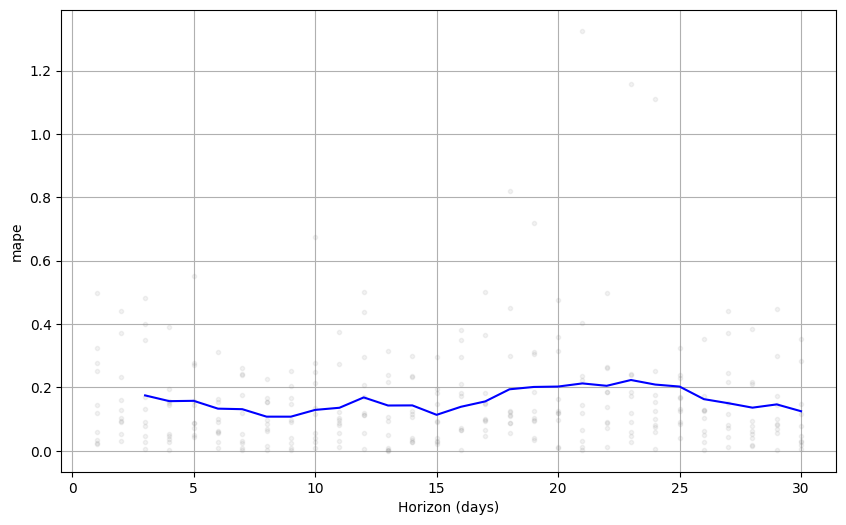

In [ ]:
# Plotting the metrics over time
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric = 'mape');

# Exploring the Error

In [ ]:
# Compute the Error / deviation
# absolute difference between predicted ('yhat') and actual ('y') values
df_cv['deviation'] = df_cv['yhat'] - df_cv['y']
# the percentage deviation of predicted from actual values
df_cv['deviation_prop'] = round((df_cv['yhat'] / df_cv['y'] - 1), 2)

In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_prop
0,2012-06-20,8218.107965,7526.011248,8942.517382,6211,2012-06-19,2007.107965,0.32
1,2012-06-21,8517.636438,7824.466297,9246.199153,5905,2012-06-19,2612.636438,0.44
2,2012-06-22,8155.284540,7459.021931,8773.378637,5823,2012-06-19,2332.284540,0.40
3,2012-06-23,7738.209754,7028.097699,8425.905038,7458,2012-06-19,280.209754,0.04
4,2012-06-24,7891.994019,7189.415558,8581.786362,6891,2012-06-19,1000.994019,0.15


In [ ]:
# Plot y, y_hat, deviation_prop
import plotly.graph_objects as go

fig = go.Figure()

# Actual values (y)
fig.add_trace(
    go.Scatter(
        x=df_cv['ds'],
        y=df_cv['y'],
        mode='lines+markers',
        name='Actual (y)',
        line=dict(color='blue'),
        yaxis='y1'
    )
)

# Forecasted values (yhat)
fig.add_trace(
    go.Scatter(
        x=df_cv['ds'],
        y=df_cv['yhat'],
        mode='lines+markers',
        name='Forecast (yhat)',
        line=dict(color='green', dash='dash'),
        yaxis='y1'
    )
)

# Deviation proportion (secondary y-axis)
fig.add_trace(
    go.Scatter(
        x=df_cv['ds'],
        y=df_cv['deviation_prop'],
        mode='lines+markers',
        name='Deviation (Prop)',
        line=dict(color='firebrick', dash='dot'),
        yaxis='y2'
    )
)

# Layout
fig.update_layout(
    title="Actual vs Forecast (y, yhat) and Deviation Over Time",
    xaxis=dict(title='Date'),
    yaxis=dict(title='y / yhat', side='left'),
    yaxis2=dict(
        title='Deviation (Proportional)',
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.01, y=0.99),
    hovermode="x unified",
    template="plotly_white",
    height=550
)

fig.show()

# Hyperparameter Tuning

In [ ]:
# Define the parameter grid to search
param_grid = {
    'changepoint_prior_scale': [0.05, 0.5],
    'seasonality_prior_scale': [10, 20],
    'holidays_prior_scale': [10, 20],
    'seasonality_mode' : ['additive', 'multiplicative']
}

In [ ]:
# Generate all combinations of parameters
all_params = list(ParameterGrid(param_grid))
all_params

[{'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prio

In [ ]:
# Placeholder for storing the results
tuning_mse = []
tuning_rmse = []
tuning_mae = []
tuning_mape = []


# Build a pipeline for the Parameter Tuning
for params in all_params:

  # build the model
  m = Prophet(
      yearly_seasonality=True,
      weekly_seasonality= True,
      holidays = holidays,
      **params)
  m.add_regressor("workingday")
  m.add_regressor("temp")
  m.add_regressor("atemp")
  m.add_regressor("hum")
  m.add_regressor("windspeed")
  m.add_regressor("weathersit_2")
  m.add_regressor("weathersit_3")
  m.add_regressor("temp_lag_1")
  m.fit(df)

  # Cross-Validation
  df_cv = cross_validation(model = m,
                          period = '15 days',
                          initial = '521 days',
                          horizon = '30 days',
                          parallel ='processes')


  # Compute and Store the Error
  mse = performance_metrics(df_cv)['mse'].mean()
  rmse = performance_metrics(df_cv)['rmse'].mean()
  mae = performance_metrics(df_cv)['mae'].mean()
  mape = performance_metrics(df_cv)['mape'].mean()

  tuning_mse.append(mse)
  tuning_rmse.append(rmse)
  tuning_mae.append(mae)
  tuning_mape.append(mape)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/or7c_bmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/ih7vcsy8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64577', 'data', 'file=/tmp/tmpikyhkmji/or7c_bmy.json', 'init=/tmp/tmpikyhkmji/ih7vcsy8.json', 'output', 'file=/tmp/tmpikyhkmji/prophet_modelkru2a33w/prophet_model-20250918175237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2012-06-19 00:00:00 and 2012-11-01 00:00:00
INFO:prophet:Applying in parallel with <conc

In [ ]:
# Parameter Tuning outcome
outcome = pd.DataFrame(all_params)
outcome['mse'] = tuning_mse
outcome['rmse'] = tuning_rmse
outcome['mae'] = tuning_mae
outcome['mape'] = tuning_mape
outcome

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,mse,rmse,mae,mape
0,0.05,10,additive,10,9.961025e+05,983.910230,771.387291,0.132447
1,0.05,10,additive,20,9.922681e+05,981.874867,769.465550,0.132142
2,0.05,10,multiplicative,10,1.623702e+06,1263.286345,984.447915,0.159443
3,0.05,10,multiplicative,20,1.623327e+06,1263.087048,984.220984,0.158915
4,0.05,20,additive,10,9.932992e+05,982.518742,770.419570,0.132182
5,0.05,20,additive,20,9.918028e+05,981.739288,769.900718,0.132126
6,0.05,20,multiplicative,10,1.622887e+06,1263.027453,988.145014,0.159843
7,0.05,20,multiplicative,20,1.637136e+06,1268.578399,988.834285,0.160121
8,0.50,10,additive,10,1.331294e+06,1139.211725,887.081758,0.156168
9,0.50,10,additive,20,1.363398e+06,1153.066027,898.856802,0.158167


In [ ]:
# Fetch the best params
best_params = all_params[tuning_mape.index(min(tuning_mape))]
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 20,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 20}

# Model Prediction

In [ ]:
# Load the daily bike sharing training data
  # training data period: 2011-01-01 to 2012-12-01
df_train = pd.read_csv("Daily Bike Sharing training.csv")
# Load the daily bike sharing future data
  # future df contains next 30 days 2012-12-02 to 2012-12-31
df_future = pd.read_csv("Daily Bike Sharing future.csv")

In [ ]:
df_train.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
696,697,11/27/2012,4,1,11,0,2,1,2,0.291667,0.281558,0.786667,0.237562,123,3836,3959
697,698,11/28/2012,4,1,11,0,3,1,1,0.296667,0.289762,0.506250,0.210821,198,5062,5260
698,699,11/29/2012,4,1,11,0,4,1,1,0.280870,0.298422,0.555652,0.115522,243,5080,5323
699,700,11/30/2012,4,1,11,0,5,1,1,0.298333,0.323867,0.649583,0.058471,362,5306,5668
700,701,12/1/2012,4,1,12,0,6,0,2,0.298333,0.316904,0.806667,0.059704,951,4240,5191


In [ ]:
df_future.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,702,12/2/2012,4,1,12,0,0,0,2,0.347500,0.359208,0.823333,0.124379,NaN,NaN,NaN
1,703,12/3/2012,4,1,12,0,1,1,1,0.452500,0.455796,0.767500,0.082721,NaN,NaN,NaN
2,704,12/4/2012,4,1,12,0,2,1,1,0.475833,0.469054,0.733750,0.174129,NaN,NaN,NaN
3,705,12/5/2012,4,1,12,0,3,1,1,0.438333,0.428012,0.485000,0.324021,NaN,NaN,NaN
4,706,12/6/2012,4,1,12,0,4,1,1,0.255833,0.258204,0.508750,0.174754,NaN,NaN,NaN


In [ ]:
# concat both together
df = pd.concat([df_train, df_future])
df.reset_index(drop = True, inplace = True)

# Data Preprocessing (Full Data)

In [ ]:
# Change the time Series variable name
# target variable as 'y'
# date as 'ds'
df = df.rename(columns = {'cnt': 'y',
                          'dteday': 'ds'})

df['ds'] = pd.to_datetime(df['ds'], format = "%m/%d/%Y")

# Create dummy variables for the categorical column 'weathersit' in DataFrame 'df'
weather_sit = pd.get_dummies(df['weathersit'], drop_first = True)
# Concatenate the original DataFrame 'df' with the dummy variables 'weather_sit'
df = pd.concat([df, weather_sit], axis = 1)

df = df.rename(columns = {2: 'weathersit_2',
                          3: 'weathersit_3'})

# Drop Variables That Are Not Needed
df.drop(columns = ['instant', 'season', 'yr', 'mnth', 'weekday',
                   'casual', 'registered'], inplace = True)

# Replace 29/30 of October 2012 with the values of 28th
# 28th because in EDA weekly seasonality is not obvious
to_replace = df.loc[df.ds == '2012-10-28'].y.values[0]
df.loc[df.ds == '2012-10-29', 'y'] = to_replace
df.loc[df.ds == '2012-10-30', 'y'] = to_replace

df.head()

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985.0,True,False
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801.0,True,False
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349.0,False,False
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562.0,False,False
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600.0,False,False


In [ ]:
df.tail()

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
726,2012-12-27,0,1,2,0.254167,0.226642,0.652917,0.350133,NaN,True,False
727,2012-12-28,0,1,2,0.253333,0.255046,0.590000,0.155471,NaN,True,False
728,2012-12-29,0,0,2,0.253333,0.242400,0.752917,0.124383,NaN,True,False
729,2012-12-30,0,0,1,0.255833,0.231700,0.483333,0.350754,NaN,False,False
730,2012-12-31,0,1,2,0.215833,0.223487,0.577500,0.154846,NaN,True,False


# Holiday Treatment (Full Data)

In [ ]:
# Define holiday events
# general holiday
gen_holidays = pd.DataFrame({'holiday': 'gen_holi',
                             'ds': df[df.holiday == 1].ds,
                             'lower_window': -2,
                             'upper_window': 2})
# Christmas
xmas = pd.DataFrame({'holiday': 'christmas',
                     'ds': pd.to_datetime(['2011-12-24', '2012-12-24']),
                             'lower_window': -5,
                             'upper_window': 3})
# New Year's Eve
nye = pd.DataFrame({'holiday': 'new_years',
                     'ds': pd.to_datetime(['2011-12-31', '2012-12-31']),
                             'lower_window': -3,
                             'upper_window': 3})
# Easter
easter = pd.DataFrame({'holiday': 'easter',
                     'ds': pd.to_datetime(['2011-04-24', '2012-04-08']),
                     'lower_window': -3,
                             'upper_window': 3})

In [ ]:
# Combine all the holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter])
holidays

,holiday,ds,lower_window,upper_window
16,gen_holi,2011-01-17,-2,2
51,gen_holi,2011-02-21,-2,2
104,gen_holi,2011-04-15,-2,2
149,gen_holi,2011-05-30,-2,2
184,gen_holi,2011-07-04,-2,2
247,gen_holi,2011-09-05,-2,2
282,gen_holi,2011-10-10,-2,2
314,gen_holi,2011-11-11,-2,2
327,gen_holi,2011-11-24,-2,2
359,gen_holi,2011-12-26,-2,2


In [ ]:
# Creating lagged values for the regressors
lag = 1
df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
df.head(1)

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3,temp_lag_1
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985.0,True,False,NaN


# Prophet Model

In [ ]:
# Just the train data (excluding last 30 points)
train = df.iloc[:-30]

In [ ]:
# Remove any NAs
train = train.dropna()

In [ ]:
# Building the Prophet model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality= True,
    holidays = holidays,
    **best_params)
m.add_regressor("workingday")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")
m.add_regressor("weathersit_2")
m.add_regressor("weathersit_3")
m.add_regressor("temp_lag_1")
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/aib06rdn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikyhkmji/5sbe3q6k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33650', 'data', 'file=/tmp/tmpikyhkmji/aib06rdn.json', 'init=/tmp/tmpikyhkmji/5sbe3q6k.json', 'output', 'file=/tmp/tmpikyhkmji/prophet_modellkt7g3kh/prophet_model-20250918175443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Forecasting

In [ ]:
# Drop columns 'ds' and 'y' from DataFrame df to create future_regressors
future_regressors = df.drop(columns = ['ds', 'y'])
# Drop rows with missing values (NaNs) from future_regressors
future_regressors = future_regressors.dropna()
# Reset the index
future_regressors.reset_index(drop = True, inplace = True)

In [ ]:
# Create a future dataframe using Prophet's make_future_dataframe method
future = m.make_future_dataframe(periods = 30)
# Concatenate future dataframe with future_regressors along axis 1 (columns)
future = pd.concat([future, future_regressors], axis = 1)

In [ ]:
future

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,weathersit_2,weathersit_3,temp_lag_1
0,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,True,False,0.344167
1,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,False,False,0.363478
2,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,False,False,0.196364
3,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,False,False,0.200000
4,2011-01-06,0,1,1,0.204348,0.233209,0.518261,0.089565,False,False,0.226957
...,...,...,...,...,...,...,...,...,...,...,...
725,2012-12-27,0,1,2,0.254167,0.226642,0.652917,0.350133,True,False,0.243333
726,2012-12-28,0,1,2,0.253333,0.255046,0.590000,0.155471,True,False,0.254167
727,2012-12-29,0,0,2,0.253333,0.242400,0.752917,0.124383,True,False,0.253333
728,2012-12-30,0,0,1,0.255833,0.231700,0.483333,0.350754,False,False,0.253333


In [ ]:
# Using the Prophet model to generate predictions for future timestamps
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,atemp,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-02,2352.109022,3.259242,1712.119168,2352.109022,2352.109022,-1504.457944,-1504.457944,-1504.457944,-168.266368,...,0.000000,0.000000,0.000000,-574.242826,-574.242826,-574.242826,0.0,0.0,0.0,847.651078
1,2011-01-03,2357.325280,-3.066943,1780.974624,2357.325280,2357.325280,-1496.207653,-1496.207653,-1496.207653,-385.525920,...,643.293622,643.293622,643.293622,-581.996764,-581.996764,-581.996764,0.0,0.0,0.0,861.117627
2,2011-01-04,2362.541537,489.648643,2194.186320,2362.541537,2362.541537,-1022.627176,-1022.627176,-1022.627176,-355.492663,...,643.293622,643.293622,643.293622,-588.257371,-588.257371,-588.257371,0.0,0.0,0.0,1339.914361
3,2011-01-05,2367.757795,747.431528,2506.406323,2367.757795,2367.757795,-709.596581,-709.596581,-709.596581,-332.821963,...,643.293622,643.293622,643.293622,-592.893632,-592.893632,-592.893632,0.0,0.0,0.0,1658.161214
4,2011-01-06,2372.974053,775.934505,2572.142551,2372.974053,2372.974053,-770.631275,-770.631275,-770.631275,-327.614365,...,643.293622,643.293622,643.293622,-595.817826,-595.817826,-595.817826,0.0,0.0,0.0,1602.342778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2012-12-27,6538.031791,2116.375282,3871.415716,6537.578939,6538.768718,-3539.992092,-3539.992092,-3539.992092,-336.296339,...,643.293622,643.293622,643.293622,-514.715582,-514.715582,-514.715582,0.0,0.0,0.0,2998.039699
726,2012-12-28,6544.103884,3673.532343,5369.391783,6543.608353,6544.871772,-2024.784118,-2024.784118,-2024.784118,-298.744522,...,643.293622,643.293622,643.293622,-526.501737,-526.501737,-526.501737,0.0,0.0,0.0,4519.319765
727,2012-12-29,6550.175977,3293.787708,5013.328083,6549.631479,6550.995587,-2381.794412,-2381.794412,-2381.794412,-315.463304,...,0.000000,0.000000,0.000000,-538.233582,-538.233582,-538.233582,0.0,0.0,0.0,4168.381565
728,2012-12-30,6556.248071,3382.646645,5125.291902,6555.674669,6557.135418,-2314.515325,-2314.515325,-2314.515325,-329.609355,...,0.000000,0.000000,0.000000,-549.571199,-549.571199,-549.571199,0.0,0.0,0.0,4241.732745


In [ ]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ds                               730 non-null    datetime64[ns]
 1   trend                            730 non-null    float64       
 2   yhat_lower                       730 non-null    float64       
 3   yhat_upper                       730 non-null    float64       
 4   trend_lower                      730 non-null    float64       
 5   trend_upper                      730 non-null    float64       
 6   additive_terms                   730 non-null    float64       
 7   additive_terms_lower             730 non-null    float64       
 8   additive_terms_upper             730 non-null    float64       
 9   atemp                            730 non-null    float64       
 10  atemp_lower                      730 non-null    float64      

# Prediction Diagnostics

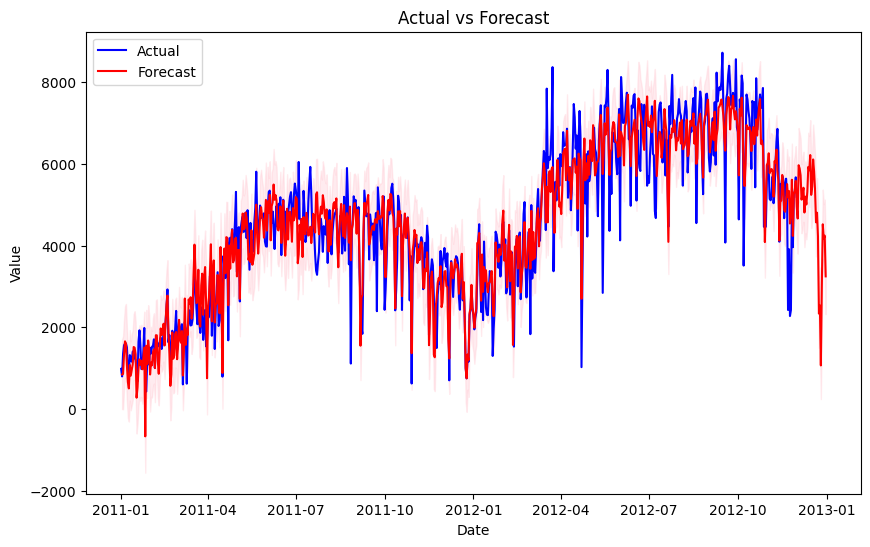

In [ ]:
# Visualize time series plot
plt.figure(figsize=(10, 6))
# Plot actual and forecasted values
plt.plot(df['ds'], df['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
# Fill the uncertainty interval (between yhat_lower and yhat_upper) with a pink color
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
# add title, xlabel, ylabel, legend
plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

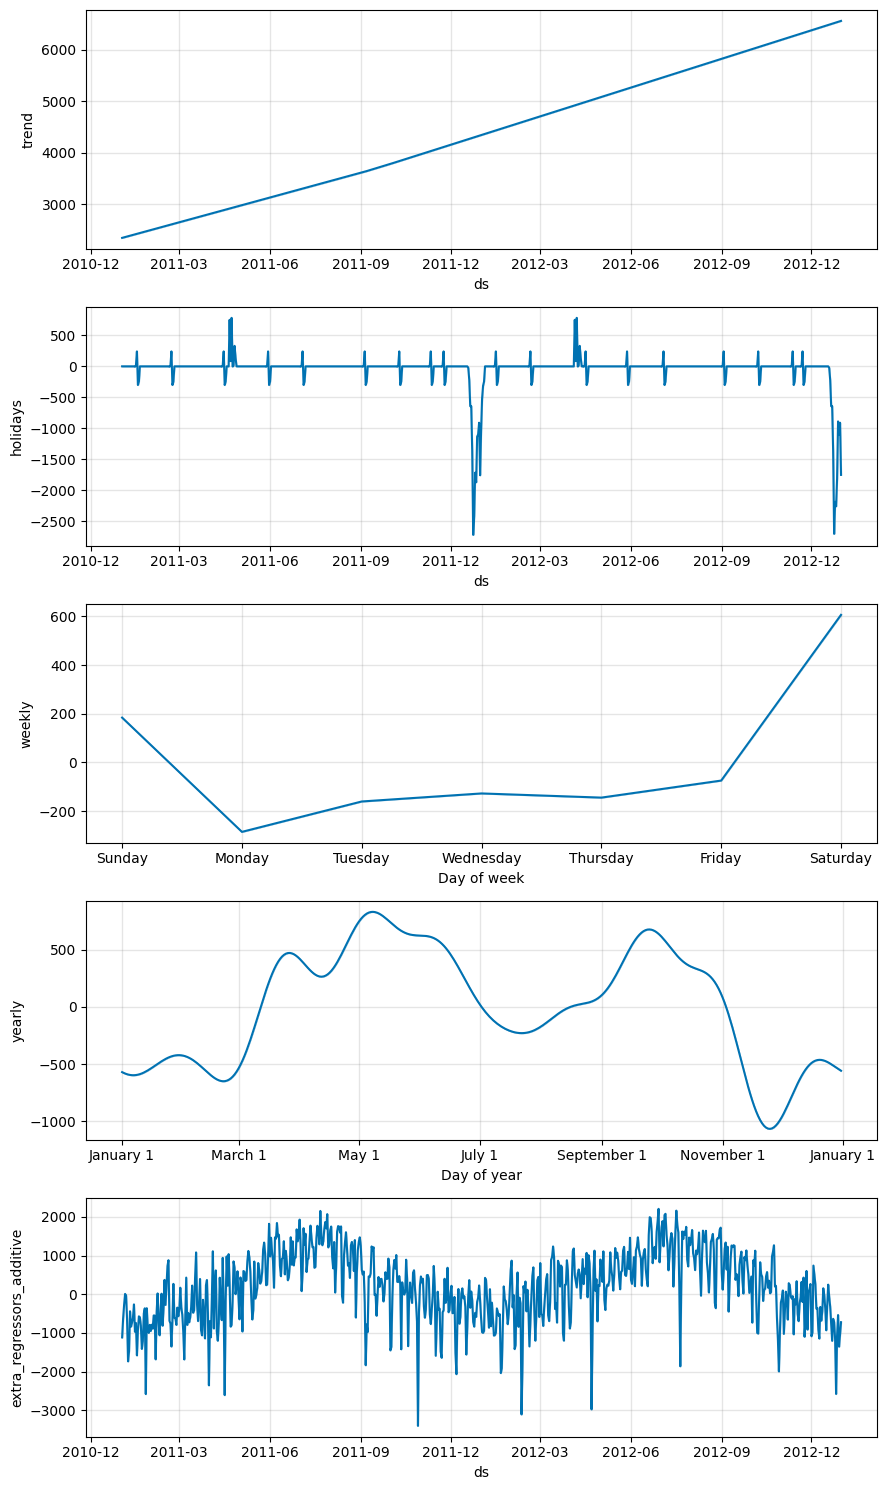

In [ ]:
# Visualize components plot
# 1. Trend: Shows the overall trend of the time series over time.
# 2. Holidays : Shows the effect of holidays on the forecast.
# 3. Weekly Seasonality: Shows patterns that repeat weekly.
# 4. Yearly Seasonality: Displays patterns that repeat annually.
# 4. Other Regressors: Displays the impact of additional regressors added to the model.
m.plot_components(forecast)
plt.show()

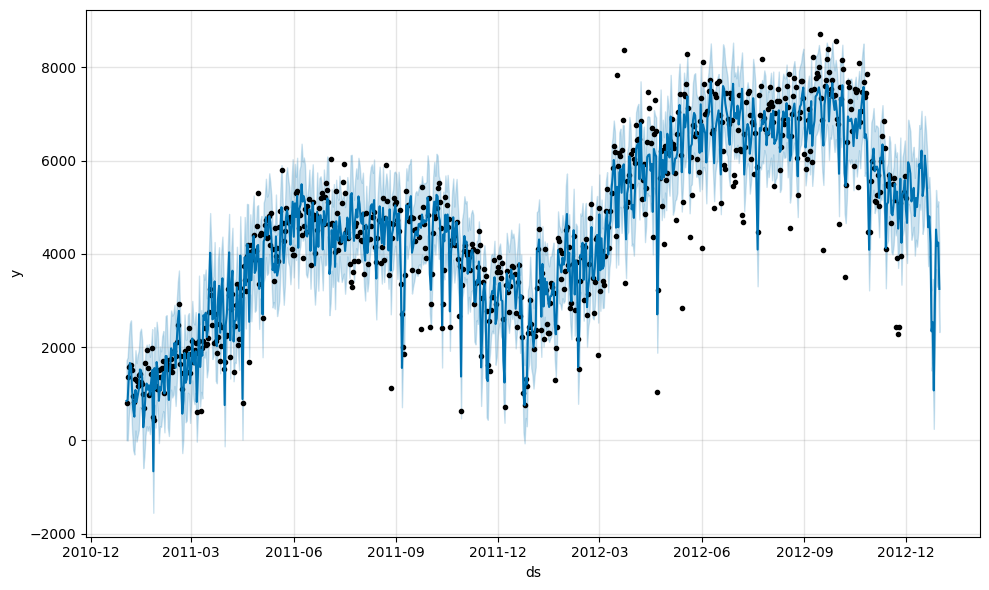

In [ ]:
# Visualize forecast plot with uncertainty bounds
m.plot(forecast)
plt.show()

In [ ]:
# Interactive visualization (using Plotly)
from prophet.plot import plot_plotly
import plotly.offline as py

# Use Prophet's plot_plotly function to generate an interactive plotly figure
fig = plot_plotly(m, forecast)
# Use Plotly's offline mode to display the interactive plotly figure
py.iplot(fig)